#### Imports and Transform

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### Load Data

In [2]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:08<00:00, 1.18MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 265kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]


#### Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3), stride=(1, 1)),   # output: (16, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),       # output: (16, 13, 13)
            nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,1)),  # output: (32, 11, 11)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),       # output: (32, 5, 5)
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=800, out_features=10, bias=True),                   # 32×5×5 = 800
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.main(x)

model = Net()
print(model)


Net(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=800, out_features=10, bias=True)
    (8): LogSoftmax(dim=1)
  )
)


#### Loss and Optimizer

In [9]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

#### Training

In [10]:
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {e+1}/{epochs} - Training loss: {running_loss/len(trainloader):.4f}")


Epoch 1/5 - Training loss: 0.1389
Epoch 2/5 - Training loss: 0.0524
Epoch 3/5 - Training loss: 0.0377
Epoch 4/5 - Training loss: 0.0311
Epoch 5/5 - Training loss: 0.0260


#### Accuracy

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.91%


#### Per Class Accuracy

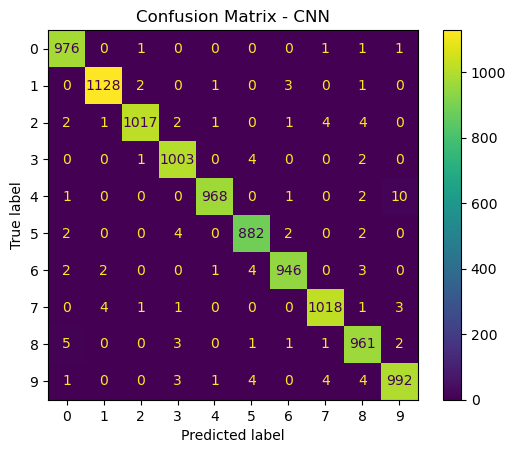

Accuracy for digit 0: 99.59%
Accuracy for digit 1: 99.38%
Accuracy for digit 2: 98.55%
Accuracy for digit 3: 99.31%
Accuracy for digit 4: 98.57%
Accuracy for digit 5: 98.88%
Accuracy for digit 6: 98.75%
Accuracy for digit 7: 99.03%
Accuracy for digit 8: 98.67%
Accuracy for digit 9: 98.32%


In [12]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot()
plt.title("Confusion Matrix - CNN")
plt.show()

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for digit {i}: {acc*100:.2f}%")